Based on the rsatoolbox tutorial: https://rsatoolbox.readthedocs.io/en/stable/demo_searchlight.html

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import seaborn as sns

from nilearn import plotting
from nilearn.image import new_img_like

In [2]:
import rsatoolbox
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed, Model
from rsatoolbox.rdm import RDMs
from rsatoolbox.vis import show_rdm, show_rdm_panel

from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from glob import glob

In [3]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [4]:
import matplotlib.colors
def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

In [5]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'derivatives', '22.1.1') # 'fmriprep_noSDC')

bidsroot = os.path.join(project_dir, 'data_bids') #'archive', 'data_bids_noIntendedFor')
deriv_dir = os.path.join(bidsroot, 'derivatives')

model_dir = os.path.join(deriv_dir, 'nilearn', 'level-1_fwhm-1.50',)

task_list = ['tonecat']
space_label = 'MNI152NLin2009cAsym'

## Make models

In [7]:
pattern_descriptors = {'tone': ['T1', 'T1', 'T1', 'T1', 
                                'T2', 'T2', 'T2', 'T2', 
                                'T3', 'T3', 'T3', 'T3', 
                                'T4', 'T4', 'T4', 'T4', ],
                       'talker': ['M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2', ],
                      }
                                  

### Stimulus RDMs

In [8]:
stim_rdm_dir = os.path.abspath('/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin')

In [10]:
stim_rdms = sorted(glob(stim_rdm_dir+'/STIM*PCA*'))
n_rdms = len(stim_rdms)
stim_rdms_name_list = []
stim_rdms_array = np.zeros((n_rdms, 16, 16))
for i, fpath in enumerate(stim_rdms):
    rdm_name = os.path.basename(fpath)[5:-4]
    stim_rdm_data = np.genfromtxt(fpath, delimiter=',', skip_header=1)
    try:
        stim_rdms_array[i] = stim_rdm_data
        stim_rdms_name_list.append(rdm_name)
    except ValueError:
        # some of the DSMs are 4x4 instead of 16x16
        # so skip them
        continue

abs_DSM_PCA_absolute1
abs_DSM_PCA_absolute2
abs_DSM_PCA_absolute3
rel_DSM_PCA_normalize1
rel_DSM_PCA_normalize2
rel_DSM_PCA_normalize3


In [12]:
model_rdms = RDMs(stim_rdms_array,
                  rdm_descriptors={'stimulus_model':stim_rdms_name_list,},
                  pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                  )

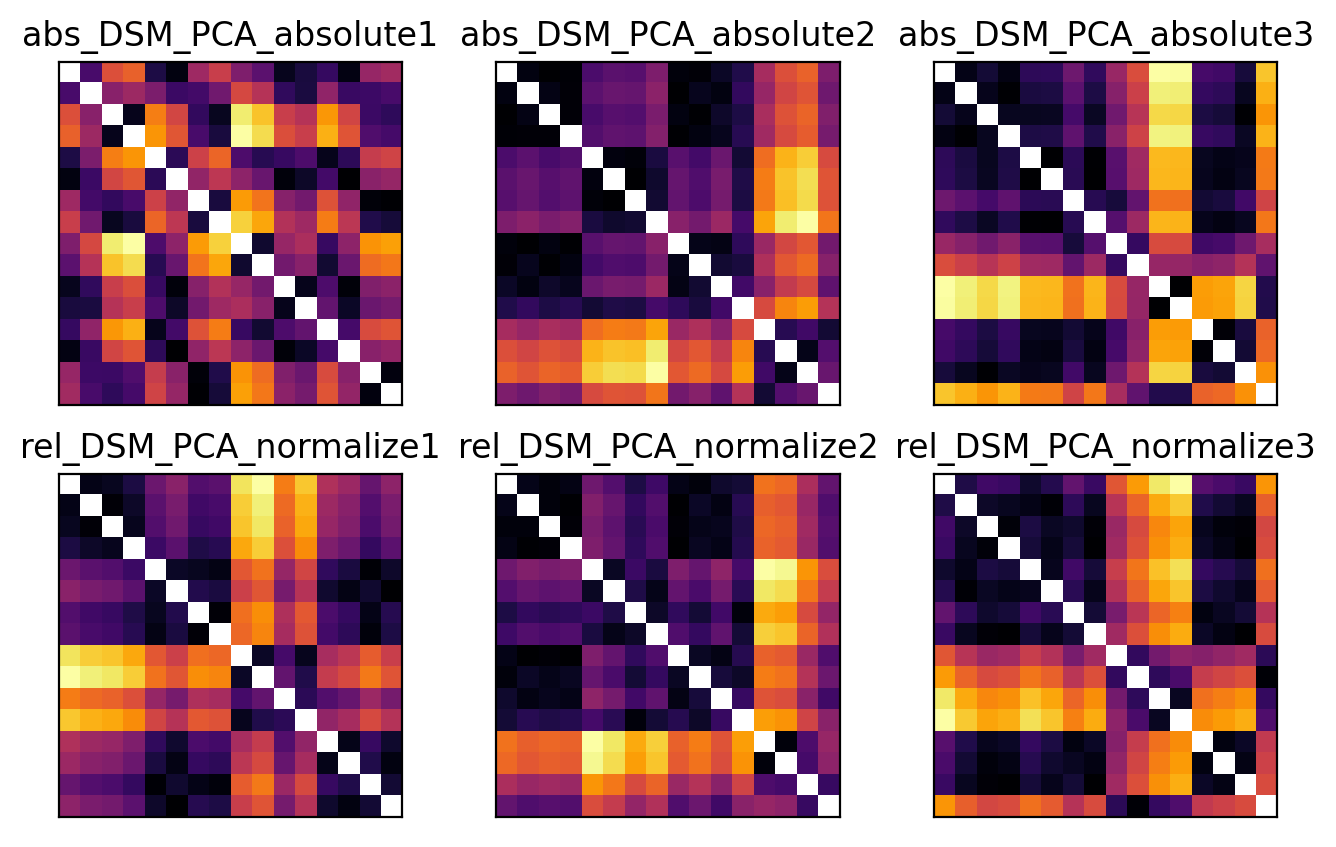

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(8,5), dpi=200)
for dx, descrip in enumerate(model_rdms.rdm_descriptors['stimulus_model']):
    spec_rdms = model_rdms.subset('stimulus_model', descrip)
    show_rdm_panel(spec_rdms, ax=axs.flat[dx], rdm_descriptor='stimulus_model', cmap='inferno',)


#### Convert to models

In [13]:
stim_models = []
for dx, descrip in enumerate(model_rdms.rdm_descriptors['stimulus_model']):
    spec_model = ModelFixed( '{} RDM'.format(descrip), model_rdms.subset('stimulus_model', descrip))
    stim_models.append(spec_model)

#### Categorical RDMs

In [14]:
# make categorical RDMs
tone_rdm = np.array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,], ])

talker_rdm = np.array([[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ], ])

rdms_array = np.array([tone_rdm, talker_rdm])

In [15]:
model_rdms = RDMs(rdms_array,
                  rdm_descriptors={'categorical_model':['tone', 'talker'],},
                  pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                 )

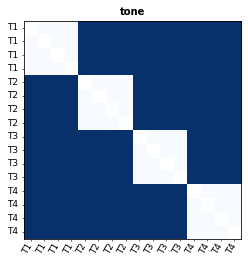

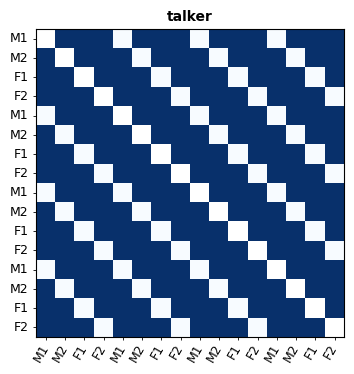

In [16]:
tone_rdms = model_rdms.subset('categorical_model','tone')
fig, ax, ret_val = show_rdm(tone_rdms, rdm_descriptor='categorical_model', 
                            pattern_descriptor='tone', cmap='Blues', figsize=(4,4))

talker_rdms = model_rdms.subset('categorical_model','talker')
fig, ax, ret_val = show_rdm(talker_rdms, rdm_descriptor='categorical_model', 
                            pattern_descriptor='talker', cmap='Blues', figsize=(4,4))

#### Convert from RDM to Model

In [18]:
tone_model = ModelFixed( 'Tone RDM', model_rdms.subset('categorical_model', 'tone'))
talker_model = ModelFixed( 'Talker RDM', model_rdms.subset('categorical_model', 'talker'))
cat_models = [tone_model, talker_model]

## Merge model lists

In [19]:
all_models = stim_models + cat_models

In [59]:
[print(x.name.split(' ')[0]) for x in all_models];

abs_DSM_PCA_absolute1
abs_DSM_PCA_absolute2
abs_DSM_PCA_absolute3
rel_DSM_PCA_normalize1
rel_DSM_PCA_normalize2
rel_DSM_PCA_normalize3
Tone
Talker


## Get searchlight and RDMs

In [22]:
# set this path to wherever you saved the folder containing the img-files
sub_id = 'FLT05'
data_folder = os.path.join(model_dir, 
                           'sub-{}_space-{}'.format(sub_id, space_label),
                           'run-all')
print(data_folder)
image_paths = sorted(glob('{}/*contrast-sound*map-tstat.nii.gz'.format(data_folder)))

mask_fpath = os.path.join(deriv_dir, 'nilearn', 'masks', 'sub-{}'.format(sub_id),
                          'space-{}'.format(space_label), 'masks-dseg',
                          'sub-{}_space-{}_mask-gm.nii.gz'.format(sub_id, space_label))

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT05_space-MNI152NLin2009cAsym/run-all


In [25]:

mask_img = nib.load(mask_fpath)
mask_data = mask_img.get_fdata()
x, y, z = mask_data.shape
'''
tmp_img = nib.load(image_paths[0])
tmp_data = tmp_img.get_fdata()
x, y, z = tmp_data.shape
mask_2d = ~np.all(data==0, axis=0)
mask_3d = mask_2d.reshape(x, y, z)
'''

# loop over all images
data = np.zeros((len(image_paths), x, y, z))
for x, im in enumerate(image_paths):
    #print(im)
    data[x] = nib.load(im).get_fdata()

# only one pattern per image
image_value = np.arange(len(image_paths))

In [27]:
# takes about 10 minutes with 2,540,000 voxels; grey matter-masked (449,000), about 3 min
centers, neighbors = get_volume_searchlight(mask_data, radius=5, threshold=0.5)

Finding searchlights...: 100%|██████████| 450556/450556 [02:19<00:00, 3224.84it/s]


Found 422815 searchlights


In [30]:
# reshape data so we have n_observastions x n_voxels
data_2d = data.reshape([data.shape[0], -1])
data_2d = np.nan_to_num(data_2d)

# Get RDMs – takes approx. 5 min
# per https://github.com/rsagroup/rsatoolbox/issues/248#issuecomment-1437358066: 
# only works with method='euclidean' if mask includes some 0s
SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='euclidean')

Calculating RDMs...: 100%|██████████| 100/100 [04:32<00:00,  2.72s/it]


## Compare RDMs

In [72]:
model_i = 7
model_id = all_models[model_i].name.split(' ')[0]

In [73]:
model_id

'Talker'

In [74]:
# takes a couple minutes to start running – don't give up too early!
# in total, takes about 15 minutes to run with 2 cores
eval_results = evaluate_models_searchlight(SL_RDM, all_models[model_i], eval_fixed, method='spearman', n_jobs=-1)

Evaluating models for each searchlight: 100%|██████████| 422815/422815 [06:53<00:00, 1022.15it/s]


In [75]:
# get the evaulation score for each voxel
# We only have one model, but evaluations returns a list. By using float we just grab the value within that list
eval_score = [np.float(e.evaluations) for e in eval_results]

/scratch/slurm-1548647/ipykernel_31504/1427774383.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


In [76]:
# Create an 3D array, with the size of mask, and
x, y, z = data.shape[1:]
RDM_brain = np.zeros([x*y*z])
RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index'])] = eval_score
RDM_brain = RDM_brain.reshape([x, y, z])

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


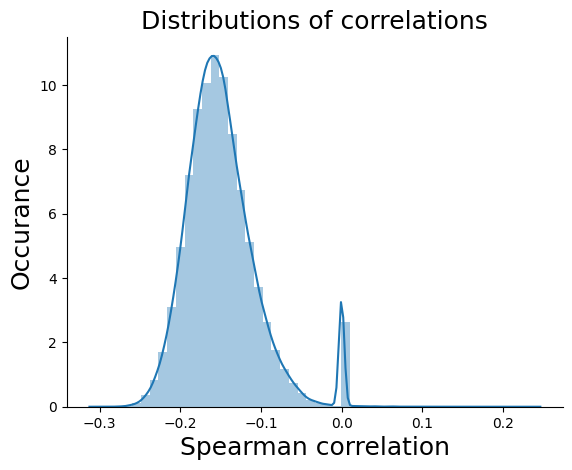

In [77]:
# plot distribution of correlations
sns.distplot(eval_score)
plt.title('Distributions of correlations', size=18)
plt.ylabel('Occurance', size=18)
plt.xlabel('Spearman correlation', size=18)
sns.despine()
plt.show()

95% threshold = -0.06856272515777932


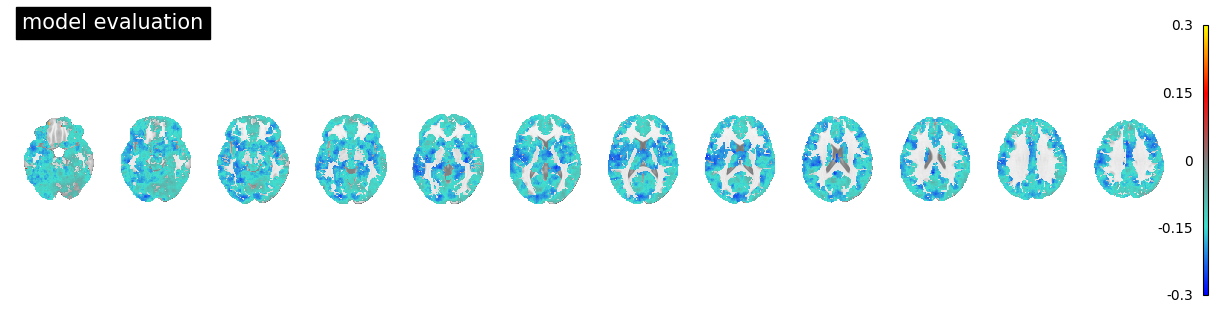

In [78]:
# lets plot the voxels above the 99th percentile
p_thresh = 95
threshold = np.percentile(eval_score, p_thresh)
print('{}% threshold = {}'.format(p_thresh, threshold))
plot_img = new_img_like(mask_img, RDM_brain)

cmap = RDMcolormapObject()

coords = range(-20, 40, 5)
fig = plt.figure(figsize=(12, 3), dpi=100)

display = plotting.plot_stat_map(
        plot_img, colorbar=True, cut_coords=coords,
        threshold=threshold,
        display_mode='z', draw_cross=False, figure=fig,
        title='model evaluation', cmap=cmap, #'Reds',
        black_bg=False, annotate=False)
plt.show()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:111: UserWarning: Threshold given was -0.06856272515777932, but the data has no values below -0.30251798033714294. 
  warnings.warn("Threshold given was {0}, but "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



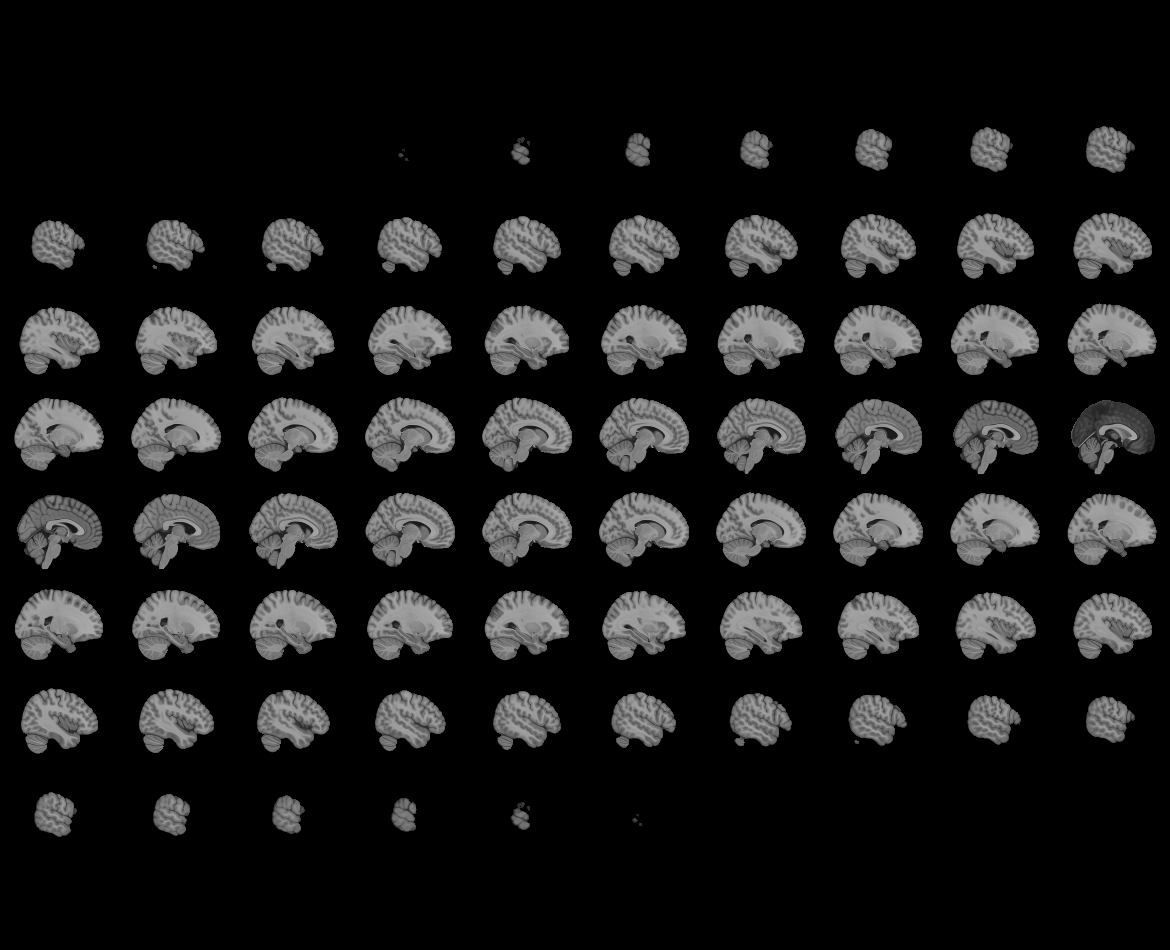
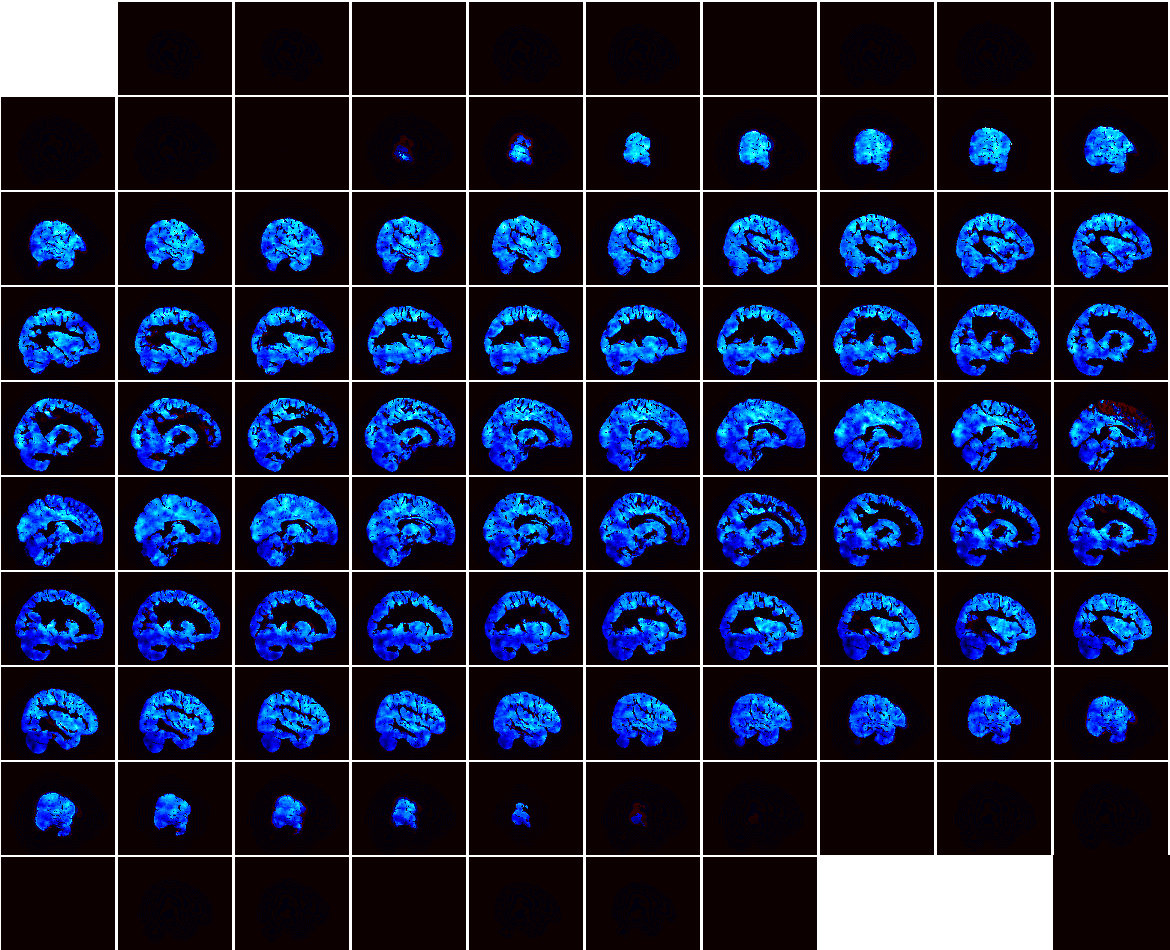

In [79]:
plotting.view_img(plot_img, threshold=threshold)

#### Save correlation image

In [81]:
out_dir = os.path.join(model_dir, 
                       'sub-{}_space-{}'.format(sub_id, space_label),
                       'rsa-searchlight')
if not os.path.exists(out_dir):
        os.makedirs(out_dir)
sub_outname = 'sub-{}_rsa-searchlight_model-{}.nii.gz'.format(sub_id, model_id)
out_fpath = os.path.join(out_dir, sub_outname)
nib.save(plot_img, out_fpath)
print('saved image to ', out_fpath)

saved image to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT05_space-MNI152NLin2009cAsym/rsa-searchlight/sub-FLT05_rsa-searchlight_model-Talker.nii.gz
